### Make the necessary imports (libraries)

In [2]:
# Import necessary libraries
import cnn_utils
from keras import layers, models
from keras.src.legacy.preprocessing.image import ImageDataGenerator


### Load the data

In [4]:
data_dict = cnn_utils.load_cifar10_from_tar()

Loading CIFAR-10 data...
Loading training batch 1...
Loading training batch 2...
Loading training batch 3...
Loading training batch 4...
Loading training batch 5...
Loading test data...
Raw data loaded successfully!
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Preprocess the data

In [5]:
data = cnn_utils.preprocess_data(data_dict)

Preprocessing data...
Preprocessing completed!
Training: (45000, 32, 32, 3), Validation: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


### Let's do a quick visualization of sample images (to also ensure we still have the correct shape)

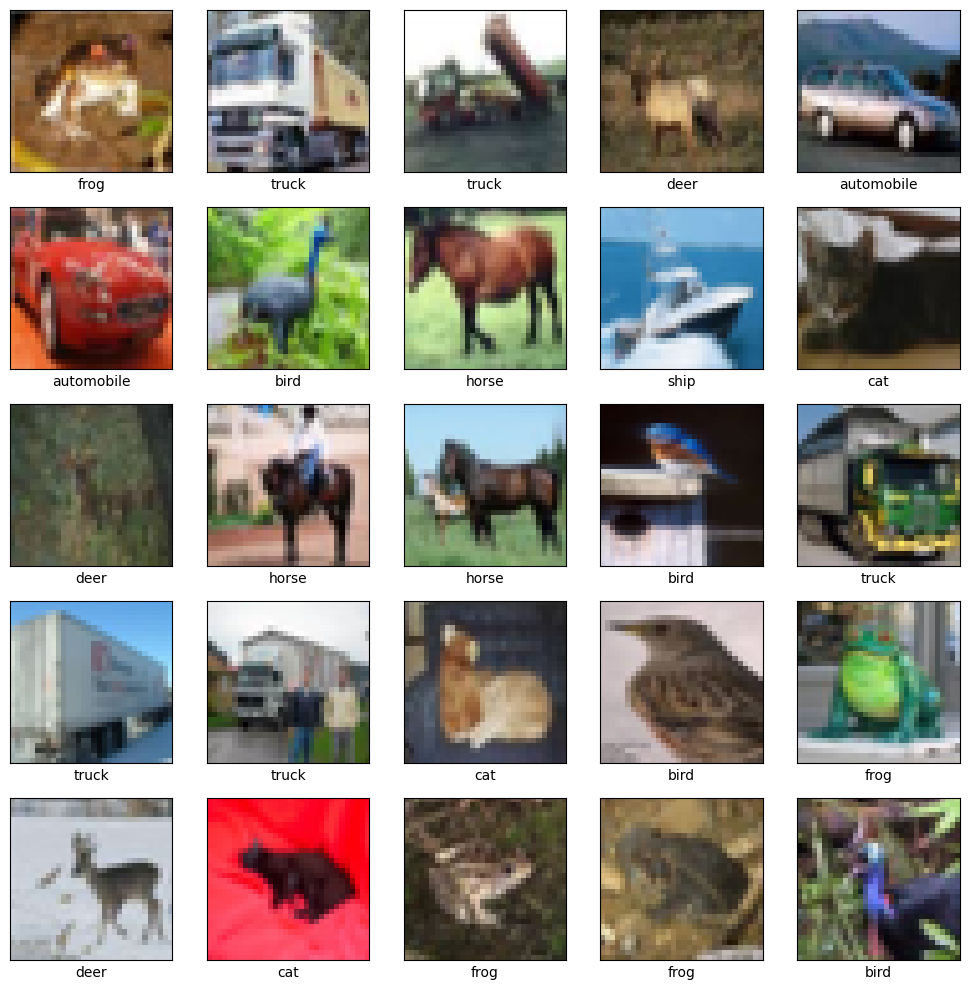

In [6]:
cnn_utils.visualize_data_samples(data)

### Augmentation of the data
Mminimal/conservative augmentation designed to be very safe:
- Tiny transformations: Only 5% shifts and 5° rotation (vs typical 10-15%)
- Basic flip: Horizontal flip only (doubles dataset safely)

In [7]:
def apply_mild_data_augmentation():
    """Apply very conservative data augmentation"""
    return ImageDataGenerator(
        horizontal_flip=True,          # Only horizontal flip
        width_shift_range=0.05,        # Very small shifts (5%)
        height_shift_range=0.05,       # Very small shifts (5%)
        rotation_range=5               # Very small rotation (5 degrees)
    )

augmentation = apply_mild_data_augmentation()
augmentation.fit(data['X_train'])

### Let's define our CNN model (architect)
Modern VGG-style CNN with consistent regularization patterns:

- 3 blocks of paired convolutions (32→64→128 filters) following VGG's "double conv + pool" pattern
- Modern techniques: BatchNormalization and explicit Activation layers (instead of inline activation)
- GlobalAveragePooling instead of Flatten (reduces overfitting)
- Progressive dropout (0.25→0.25→0.5)
- Lightweight classifier (128 neurons vs typical 512+)


In [8]:
# Define the CNN model architecture
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()

    # First block - keep successful pattern
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Slightly lower dropout

    # Second block
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Third block
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    # Keep the successful GlobalAveragePooling
    model.add(layers.GlobalAveragePooling2D())

    # Simplified classifier
    model.add(layers.Dense(128))  # Even smaller
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))  # Lower dropout for stability
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [9]:
model = create_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_utils.print_model_summary(model)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 307,114 (1.17 MB)

 Trainable params: 305,962 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)


📊 Total Parameters: 307,114


In [10]:
from keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #,
]

history = cnn_utils.train_model(model, data, augmentation=augmentation, callbacks=callbacks)


Starting model training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3095 - loss: 1.9598 - val_accuracy: 0.4850 - val_loss: 1.4616
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.5405 - loss: 1.2907 - val_accuracy: 0.5942 - val_loss: 1.1464
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.6036 - loss: 1.1216 - val_accuracy: 0.4586 - val_loss: 1.6722
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.6459 - loss: 1.0096 - val_accuracy: 0.6110 - val_loss: 1.1888
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6854 - loss: 0.9075 - val_accuracy: 0.6790 - val_loss: 0.9145
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7054 - loss: 0.8611 - val_accuracy: 0.6290 - val_loss: 1.1807
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7207 - loss: 0.8071 - val_accuracy: 0.6674 - val_loss: 1.0059
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7381 - loss: 0.7666 - val_accurac

### Let's show the evaluation result

MODEL EVALUATION


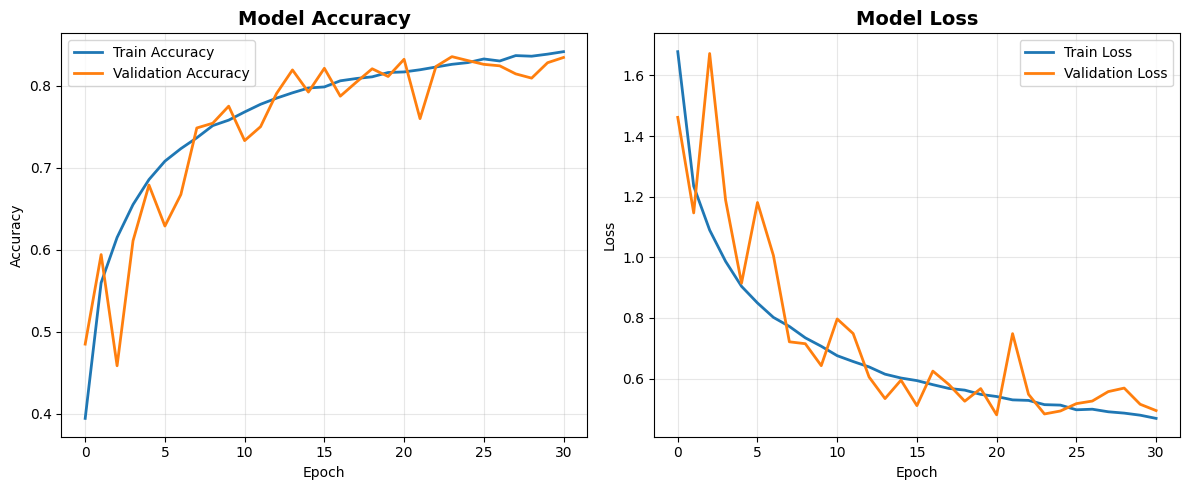


🎯 Final Test Results:
   Test Accuracy: 0.8265
   Test Loss: 0.5055

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.89      0.85      1000
  automobile       0.90      0.96      0.93      1000
        bird       0.85      0.68      0.75      1000
         cat       0.81      0.54      0.65      1000
        deer       0.77      0.84      0.81      1000
         dog       0.78      0.73      0.75      1000
        frog       0.70      0.95      0.80      1000
       horse       0.84      0.89      0.86      1000
        ship       0.93      0.90      0.92      1000
       truck       0.91      0.89      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000



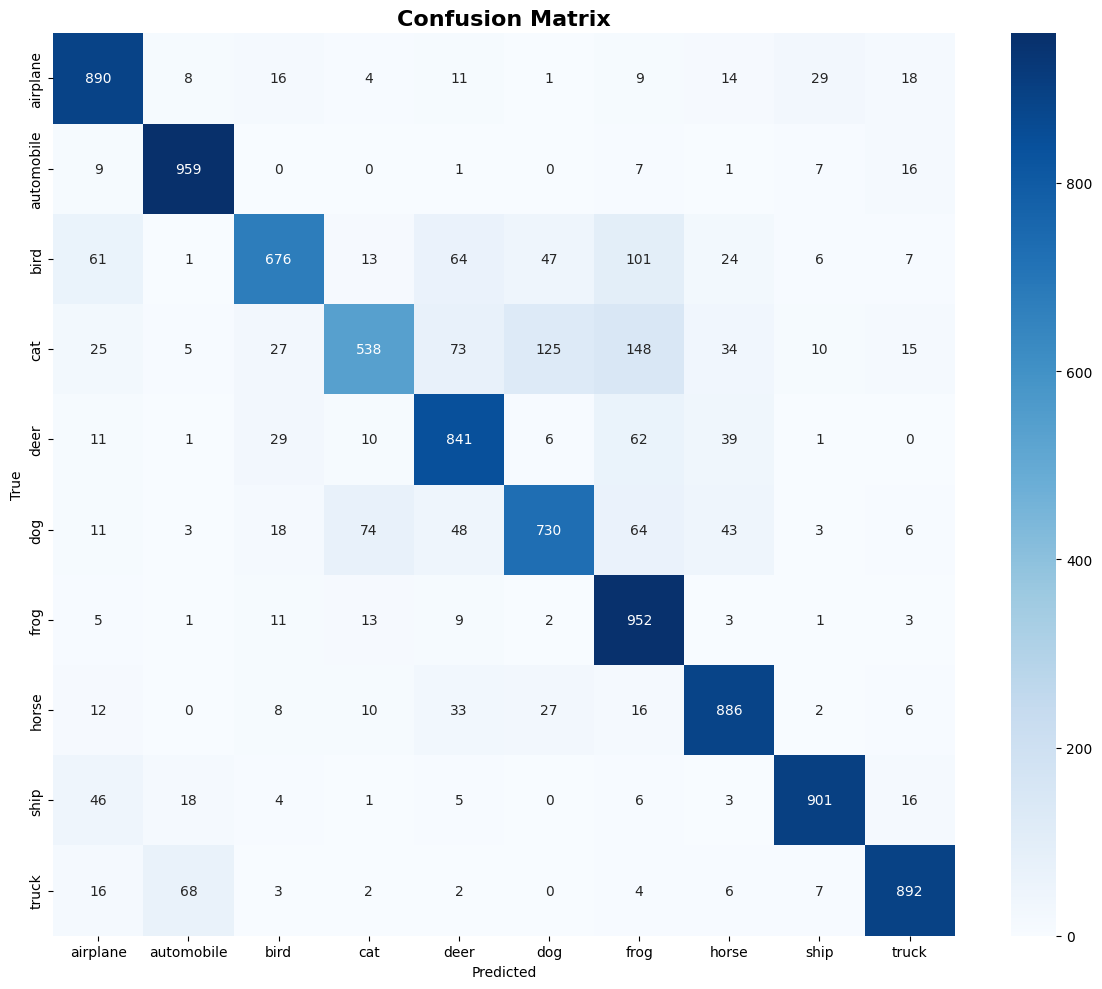

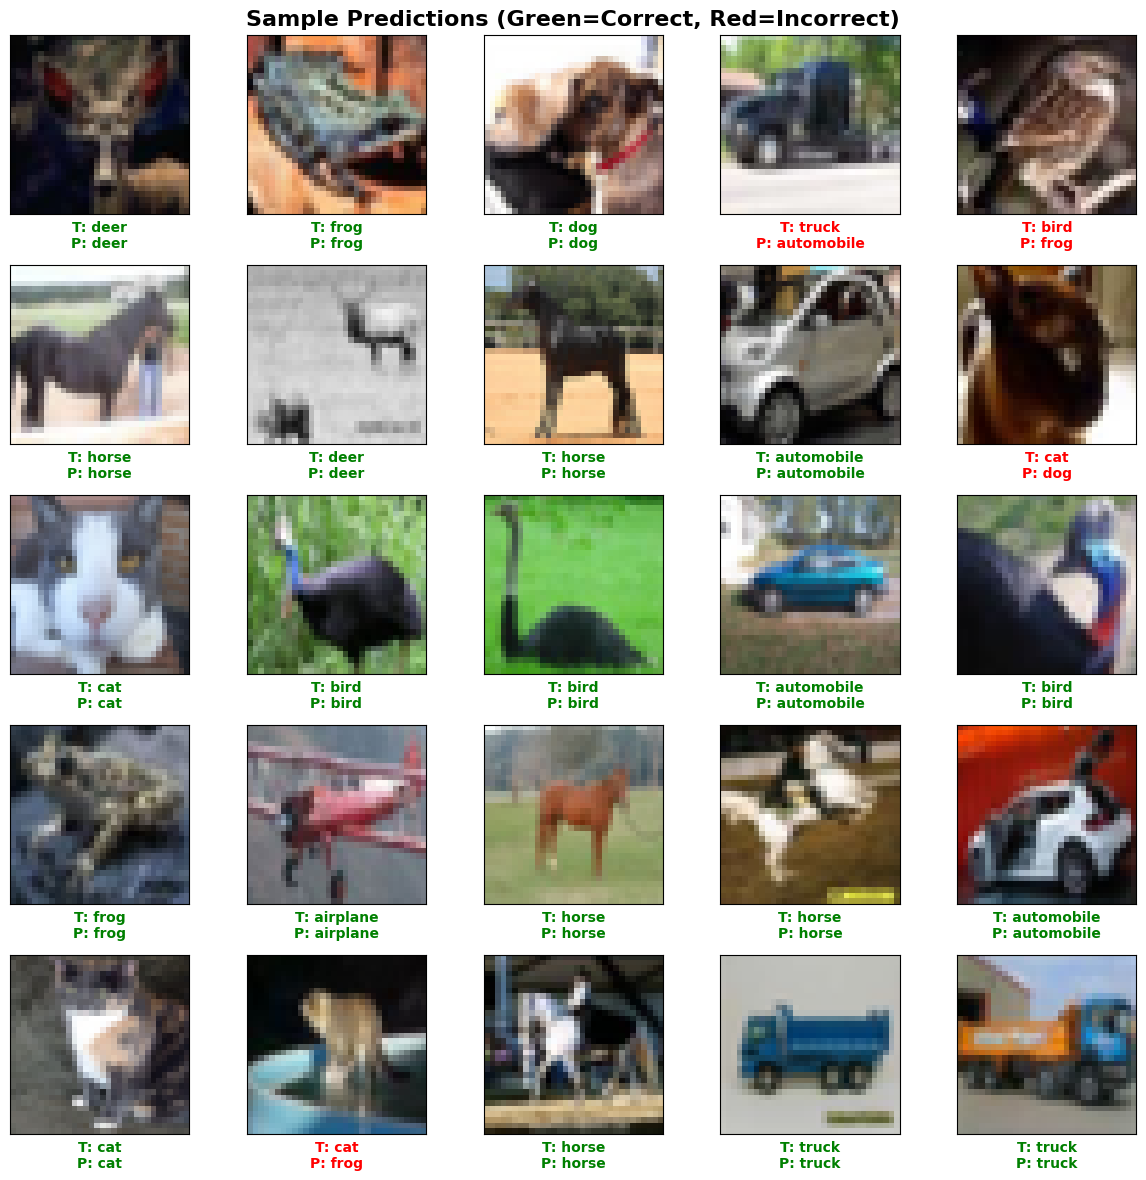

In [11]:
cnn_utils.evaluate_model(model, data, history)